In [1]:
# Import packages
import networkx as nx
import matplotlib.pyplot as plt
from stark_qa.tools.graph import k_hop_subgraph
from stark_qa import load_skb, load_qa
from langchain_community.graphs import NetworkxEntityGraph

In [2]:
# Load Stark QA and SKB
skb = load_skb("prime", download_processed=True, root="/scratch")

qa_dataset = load_qa("prime", root="/scratch")
idx_split = qa_dataset.get_idx_split()

Loading from /scratch/prime/processed!
Use file from /root/.cache/huggingface/hub/datasets--snap-stanford--stark/snapshots/e3387ba9c873528521e125c3da687092d9872104/qa/prime/stark_qa/stark_qa_human_generated_eval_uncleaned.csv.


In [76]:
# Load the first sample
query, q_id, answer_ids, _ = qa_dataset[59]

In [77]:
query

'What disease shares a hierarchical connection as both a subtype and supertype with malignant pericardial mesothelioma and also has a related hierarchical link to epicardium cancer?'

In [78]:
type(answer_ids), answer_ids

(list, [36973])

In [79]:
# K-Hop Subgraph construction, starting from the answer_ids
subset, edge_index, _, edge_mask = k_hop_subgraph(answer_ids, num_hops=1, edge_index=skb.edge_index)

In [80]:
subset

tensor([36149, 36150, 36973, 94622, 96120])

In [53]:
g_node_types = skb.node_types[subset]
g_edge_types = skb.edge_types[edge_mask]

In [8]:
g_node_types.shape, g_edge_types.shape

(torch.Size([4]), torch.Size([6]))

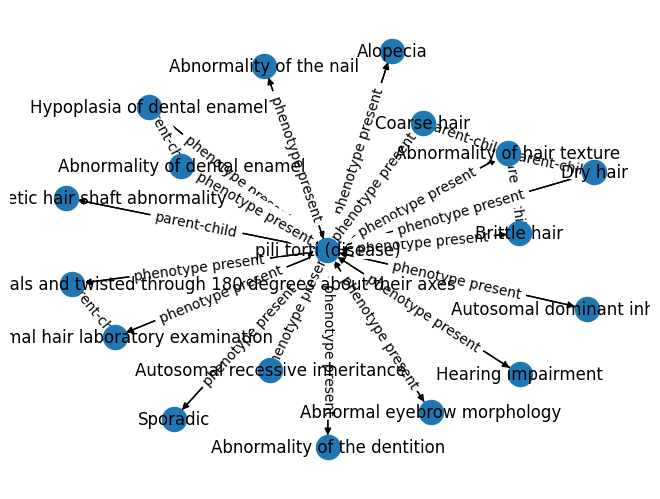

In [54]:
# Using networkx to visualize the graph
G = nx.DiGraph()

node_list = subset.numpy()
edge_list = edge_index.transpose(1, 0).numpy()
edge_types = g_edge_types.numpy()

for n in node_list:
    G.add_node(skb[n].name)
for i, e in enumerate(edge_list):
    G.add_edge(skb[e[0]].name, skb[e[1]].name, relation=skb.edge_type_dict[edge_types[i]], label=skb.edge_type_dict[edge_types[i]])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.show()

In [55]:
mygraph = NetworkxEntityGraph(G)
mygraph.get_triples() # a list of (head, tail, relation)

[('Hearing impairment', 'pili torti (disease)', 'phenotype present'),
 ('Abnormal eyebrow morphology', 'pili torti (disease)', 'phenotype present'),
 ('Abnormality of the dentition', 'pili torti (disease)', 'phenotype present'),
 ('Abnormality of dental enamel',
  'Hypoplasia of dental enamel',
  'parent-child'),
 ('Abnormality of dental enamel', 'pili torti (disease)', 'phenotype present'),
 ('Abnormality of the nail', 'pili torti (disease)', 'phenotype present'),
 ('Autosomal dominant inheritance',
  'pili torti (disease)',
  'phenotype present'),
 ('Abnormality of hair texture', 'Coarse hair', 'parent-child'),
 ('Abnormality of hair texture', 'Brittle hair', 'parent-child'),
 ('Abnormality of hair texture', 'Dry hair', 'parent-child'),
 ('Abnormality of hair texture', 'pili torti (disease)', 'phenotype present'),
 ('Alopecia', 'pili torti (disease)', 'phenotype present'),
 ('Abnormal hair laboratory examination',
  'Hair shafts flattened at irregular intervals and twisted through 18

In [56]:
str(mygraph.get_triples()).strip('[]')

"('Hearing impairment', 'pili torti (disease)', 'phenotype present'), ('Abnormal eyebrow morphology', 'pili torti (disease)', 'phenotype present'), ('Abnormality of the dentition', 'pili torti (disease)', 'phenotype present'), ('Abnormality of dental enamel', 'Hypoplasia of dental enamel', 'parent-child'), ('Abnormality of dental enamel', 'pili torti (disease)', 'phenotype present'), ('Abnormality of the nail', 'pili torti (disease)', 'phenotype present'), ('Autosomal dominant inheritance', 'pili torti (disease)', 'phenotype present'), ('Abnormality of hair texture', 'Coarse hair', 'parent-child'), ('Abnormality of hair texture', 'Brittle hair', 'parent-child'), ('Abnormality of hair texture', 'Dry hair', 'parent-child'), ('Abnormality of hair texture', 'pili torti (disease)', 'phenotype present'), ('Alopecia', 'pili torti (disease)', 'phenotype present'), ('Abnormal hair laboratory examination', 'Hair shafts flattened at irregular intervals and twisted through 180 degrees about their 

In [57]:
from ollama_utils import ollama_stream



In [58]:
question = 'How do people get this illness'

mygraph = NetworkxEntityGraph(G)
question += str(mygraph.get_triples()).strip('[]')


In [65]:
question

"How do people get this illness('Hearing impairment', 'pili torti (disease)', 'phenotype present'), ('Abnormal eyebrow morphology', 'pili torti (disease)', 'phenotype present'), ('Abnormality of the dentition', 'pili torti (disease)', 'phenotype present'), ('Abnormality of dental enamel', 'Hypoplasia of dental enamel', 'parent-child'), ('Abnormality of dental enamel', 'pili torti (disease)', 'phenotype present'), ('Abnormality of the nail', 'pili torti (disease)', 'phenotype present'), ('Autosomal dominant inheritance', 'pili torti (disease)', 'phenotype present'), ('Abnormality of hair texture', 'Coarse hair', 'parent-child'), ('Abnormality of hair texture', 'Brittle hair', 'parent-child'), ('Abnormality of hair texture', 'Dry hair', 'parent-child'), ('Abnormality of hair texture', 'pili torti (disease)', 'phenotype present'), ('Alopecia', 'pili torti (disease)', 'phenotype present'), ('Abnormal hair laboratory examination', 'Hair shafts flattened at irregular intervals and twisted th

In [64]:
response = ollama_stream(question)
for token in response:
    full_response += token

ConnectError: [Errno 111] Connection refused